데이터 불러오기

In [322]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [323]:
df = pd.read_csv('/content/sample_data/potato_weather.csv', index_col=0)
df = df.dropna(axis=0)
df = df.drop(['Avg_Price'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['sobimul'],axis=1)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [324]:
df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

In [325]:
df.tail()

,Date,Rain,Wind,Temp,Oil,nongmul,Price,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,20.0,1889.31,8.7,415.0,0,0,0,0
2391,2022-09-27,0.0,1.6,20.9,1889.31,8.7,415.0,1,0,0,0
2392,2022-09-28,0.0,1.8,20.4,1889.31,8.7,415.0,0,1,0,0
2393,2022-09-29,0.0,1.4,20.4,1889.31,8.7,415.0,0,0,1,0
2394,2022-09-30,0.0,1.6,20.7,1889.31,8.7,415.0,0,0,0,1


데이터 전처리

In [326]:
# 21일치의 input으로 7일치의 output을 생산
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 21
predict_day = 7

In [327]:
x = df.iloc[:, 1:]
y = df.iloc[:,[6]]

In [328]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x.values)
x.loc[:,:] = scaler.transform(x.values)

In [329]:
x = x.to_numpy()
y = y.to_numpy()

In [330]:
train_x = []
train_y = []
# 묶음의 개수가 2370개 ( 2394: x의 마지막 - seq_length  ), 추후 변수 대입 예정
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
    train_x.append(_x) # dataX 리스트에 추가 / add to dataX's list
    train_y.append(_y) # dataY 리스트에 추가 / add to dataY's list

In [331]:
print(len(train_x))
print(len(train_y))

2367
2367


In [332]:
train_x = np.reshape(train_x, (2367, 21, 10))

In [333]:
train_x.shape

(2367, 21, 10)

In [334]:
train_y = np.reshape(train_y, (2367, 21))

In [335]:
train_y.shape

(2367, 21)

LSTM 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [ ]:
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, 21, 10), return_sequences=True, stateful=True))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (1, 21, 32)               5504      
                                                                 
 dropout_3 (Dropout)         (1, 21, 32)               0         
                                                                 
 dense_10 (Dense)            (1, 21, 1)                33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50

for epoch_idx in range(num_epochs):
  print('epochs:' + str(epoch_idx))
  model.fit(train_x, train_y, epochs=1, batch_size=1, verbose=2, shuffle=False)
  model.reset_states()

epochs:0
2367/2367 - 97s - loss: 101040.9688 - mae: 296.8571 - 97s/epoch - 41ms/step
epochs:1
2367/2367 - 12s - loss: 65233.3320 - mae: 227.9467 - 12s/epoch - 5ms/step
epochs:2
2367/2367 - 12s - loss: 41745.3242 - mae: 167.9737 - 12s/epoch - 5ms/step
epochs:3
2367/2367 - 12s - loss: 27182.1523 - mae: 122.5404 - 12s/epoch - 5ms/step
epochs:4
2367/2367 - 12s - loss: 19822.2480 - mae: 104.1943 - 12s/epoch - 5ms/step
epochs:5
2367/2367 - 12s - loss: 16847.7812 - mae: 99.7002 - 12s/epoch - 5ms/step
epochs:6
2367/2367 - 12s - loss: 16059.1973 - mae: 99.9900 - 12s/epoch - 5ms/step
epochs:7
2367/2367 - 12s - loss: 15888.6943 - mae: 100.7427 - 12s/epoch - 5ms/step
epochs:8
2367/2367 - 12s - loss: 15991.1719 - mae: 101.3749 - 12s/epoch - 5ms/step
epochs:9
2367/2367 - 12s - loss: 15430.1602 - mae: 98.9760 - 12s/epoch - 5ms/step
epochs:10
2367/2367 - 12s - loss: 14613.7559 - mae: 94.5456 - 12s/epoch - 5ms/step
epochs:11
2367/2367 - 12s - loss: 13165.9404 - mae: 87.3011 - 12s/epoch - 5ms/step
epoch

In [336]:
model.evaluate(train_x, train_y, batch_size=1)

2367/2367 [==============================] - 10s 4ms/step - loss: 3327.0461 - mae: 45.5255


[3327.046142578125, 45.52552795410156]

In [342]:
train_sample = train_x[0]
train_sample = np.reshape(train_sample, (1, 21, 10))
print(train_sample.shape)

(1, 21, 10)


In [343]:
predicted_price_sample = model.predict(train_sample, batch_size=1, verbose=1)

1/1 [==============================] - 0s 34ms/step


In [345]:
print(predicted_price_sample)
print(predicted_price_sample.shape)

[[[409.88892]
  [484.13934]
  [491.7353 ]
  [465.73062]
  [463.48535]
  [480.8197 ]
  [480.71878]
  [480.476  ]
  [451.0503 ]
  [448.19446]
  [456.93692]
  [479.52118]
  [460.53156]
  [441.30627]
  [425.6443 ]
  [442.2915 ]
  [441.90143]
  [462.13196]
  [451.3671 ]
  [428.72696]
  [414.89703]]]
(1, 21, 1)


In [348]:
predicted_price_sample = np.reshape(predicted_price_sample, (21,))

In [349]:
predicted_price_sample

array([409.88892, 484.13934, 491.7353 , 465.73062, 463.48535, 480.8197 ,
       480.71878, 480.476  , 451.0503 , 448.19446, 456.93692, 479.52118,
       460.53156, 441.30627, 425.6443 , 442.2915 , 441.90143, 462.13196,
       451.3671 , 428.72696, 414.89703], dtype=float32)

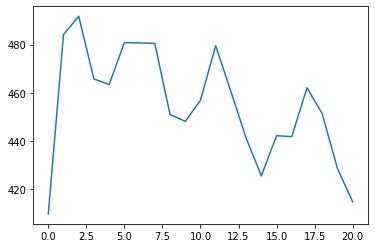

In [350]:
plt.plot(predicted_price_sample)

In [ ]:
predicted_price = model.predict(train_x, batch_size=1, verbose=1)

2367/2367 [==============================] - 6s 2ms/step


In [ ]:
# 테스트
print(train_y[0], train_y[0].shape)

[427. 402. 402. 402. 412. 401. 401. 401. 401. 386. 386. 386. 386. 386.
 410. 416. 416. 416. 416. 409. 409.] (21,)


In [ ]:
# 테스트
print(predicted_price[0], predicted_price[0].shape)

[[409.88892]
 [484.13934]
 [491.7353 ]
 [465.73062]
 [463.48535]
 [480.8197 ]
 [480.71878]
 [480.476  ]
 [451.0503 ]
 [448.19446]
 [456.93692]
 [479.52118]
 [460.53156]
 [441.30627]
 [425.6443 ]
 [442.2915 ]
 [441.90143]
 [462.13196]
 [451.3671 ]
 [428.72696]
 [414.89703]] (21, 1)


In [ ]:
# 테스트
predicted_price_test = np.reshape(predicted_price[0], (21,))

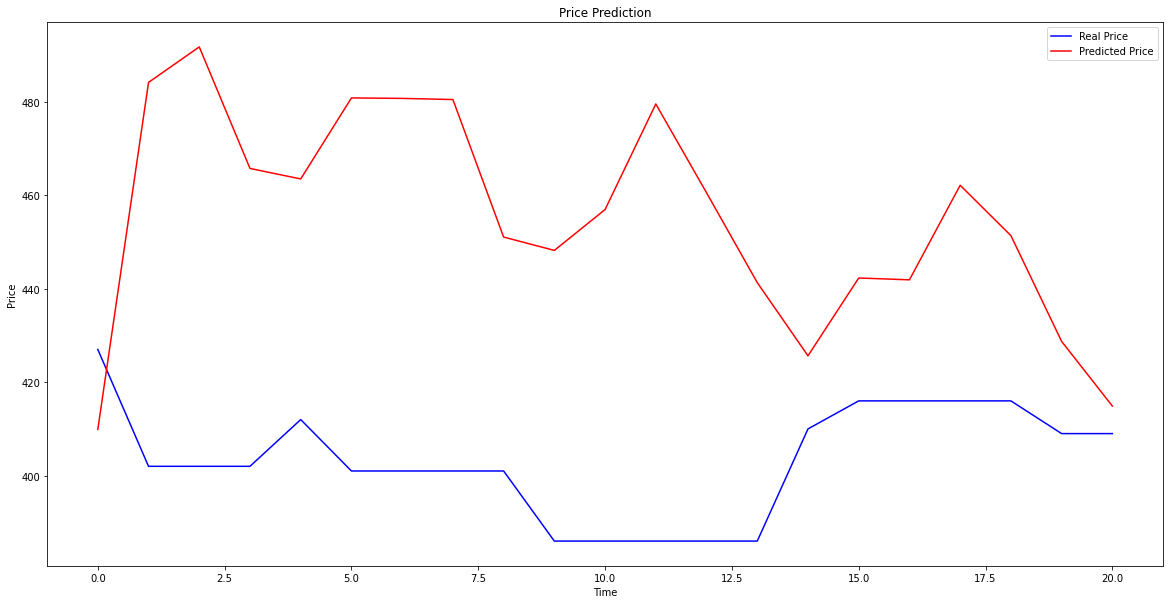

In [ ]:
# 테스트
plt.figure(figsize=(20,10))
plt.plot(train_y[0], color = 'blue', label = 'Real Price')
plt.plot(predicted_price_test, color = 'red', label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
train_y = np.delete(train_y, np.s_[1:], axis=1)
predicted_price = np.delete(predicted_price, np.s_[1:], axis=1)

In [ ]:
predicted_price = np.reshape(predicted_price, (2367, 1))

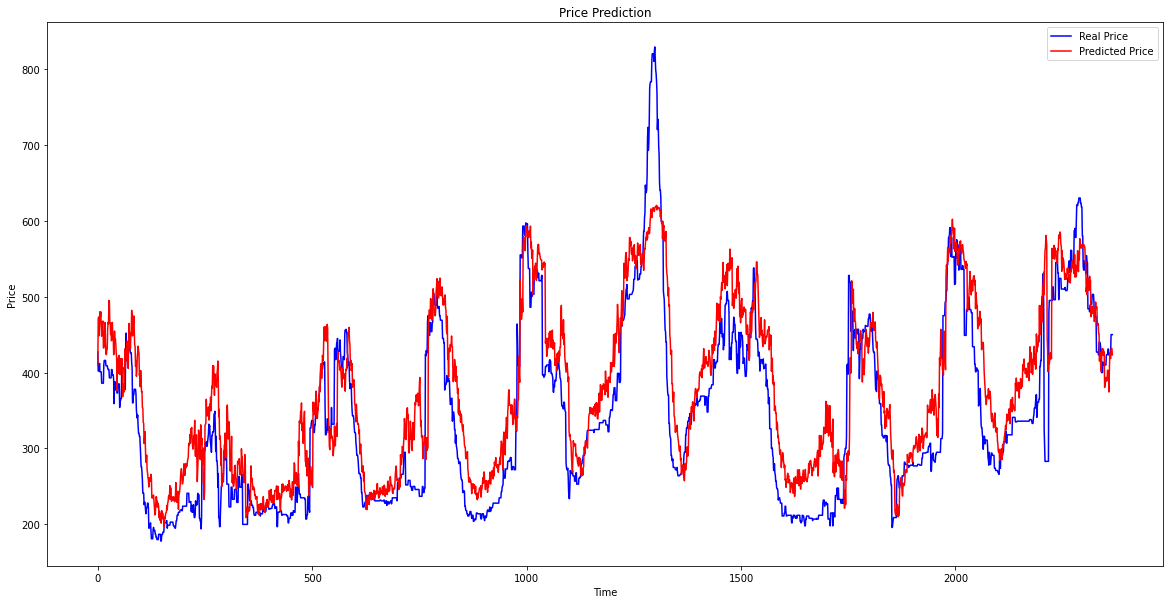

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_y, color = 'blue', label = 'Real Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
